# COVID19 - Building a model from the clinical data

In this notebook I will unify, explore and clean the clinical data in this repository. After that I will try to build a model to predict whether the coronavirus test will be positive or negative, ie, clinically diagnose COVID19

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import glob
import os

os.chdir('../data/') # Change the working directory to the data directory
all_data_available = glob.glob('*.csv')
print(all_data_available)

['04-07_carbonhealth_and_braidhealth.csv', '04-14_carbonhealth_and_braidhealth.csv', '04-21_carbonhealth_and_braidhealth.csv', '04-28_carbonhealth_and_braidhealth.csv', '05-05_carbonhealth_and_braidhealth.csv', '05-12_carbonhealth_and_braidhealth.csv', '05-19_carbonhealth_and_braidhealth.csv', '05-26_carbonhealth_and_braidhealth.csv', '06-02_carbonhealth_and_braidhealth.csv', '06-09_carbonhealth_and_braidhealth.csv', '06-16_carbonhealth_and_braidhealth.csv', '06-23_carbonhealth_and_braidhealth.csv', '06-30_carbonhealth_and_braidhealth.csv', '07-07_carbonhealth_and_braidhealth.csv', '07-14_carbonhealth_and_braidhealth.csv', '07-21_carbonhealth_and_braidhealth.csv', '07-28_carbonhealth_and_braidhealth.csv', '08-04_carbonhealth_and_braidhealth.csv', '08-11_carbonhealth_and_braidhealth.csv', '08-18_carbonhealth_and_braidhealth.csv', '08-25_carbonhealth_and_braidhealth.csv', '09-01_carbonhealth_and_braidhealth.csv', '09-08_carbonhealth_and_braidhealth.csv', '09-15_carbonhealth_and_braidheal

In [2]:
# We load all data from the repo

all_data = None #A workaround to declare the all_data variable for use later

for file in all_data_available:     
    df = pd.read_csv("../data/" + file)    
    print(file, df["covid19_test_results"].value_counts()["Positive"] / len(df["covid19_test_results"]), "Size:", len(df))
    try:
        df["rapid_flu_results"] = df["rapid_flu_results"].astype("object") #Because in 2 files all values are null and because of that pandas changes the column type to float
        if all_data is None:
            all_data = df
        else:
            
            all_data = pd.merge(all_data, df, how="outer")

    except Exception as e:
        print(file, "could not be merged:", e)
        print(len(df), "rows were left out")

    print("All data size:", len(all_data))

04-07_carbonhealth_and_braidhealth.csv 0.061224489795918366 Size: 735
All data size: 735
04-14_carbonhealth_and_braidhealth.csv 0.08365019011406843 Size: 263
All data size: 998
04-21_carbonhealth_and_braidhealth.csv 0.03074141048824593 Size: 1106
All data size: 2104
04-28_carbonhealth_and_braidhealth.csv 0.011996572407883462 Size: 1167
All data size: 3271
05-05_carbonhealth_and_braidhealth.csv 0.018738288569643973 Size: 1601
All data size: 4872
05-12_carbonhealth_and_braidhealth.csv 0.03541315345699832 Size: 593
All data size: 5465
05-19_carbonhealth_and_braidhealth.csv 0.05353319057815846 Size: 934
All data size: 6399
05-26_carbonhealth_and_braidhealth.csv 0.04533333333333334 Size: 750
All data size: 7149
06-02_carbonhealth_and_braidhealth.csv 0.03134479271991911 Size: 989
All data size: 8138
06-09_carbonhealth_and_braidhealth.csv 0.010725552050473186 Size: 1585
All data size: 9723
06-16_carbonhealth_and_braidhealth.csv 0.011756569847856155 Size: 1446
All data size: 11169
06-23_carbon

In [3]:
#All Data info
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93995 entries, 0 to 93994
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   batch_date                     93995 non-null  object 
 1   test_name                      93995 non-null  object 
 2   swab_type                      93995 non-null  object 
 3   covid19_test_results           93995 non-null  object 
 4   age                            93995 non-null  int64  
 5   high_risk_exposure_occupation  93826 non-null  object 
 6   high_risk_interactions         69168 non-null  object 
 7   diabetes                       93995 non-null  object 
 8   chd                            93995 non-null  object 
 9   htn                            93995 non-null  object 
 10  cancer                         93995 non-null  object 
 11  asthma                         93995 non-null  object 
 12  copd                           93995 non-null 

In [4]:
#The total rate of positive values in all the dataset
all_data["covid19_test_results"].value_counts()["Positive"] / len(all_data["covid19_test_results"])

0.013968828129155807

In [5]:
print(len(all_data))
print(all_data.index.nunique())
print(all_data.drop_duplicates().shape)
all_data.covid19_test_results.value_counts()


93995
93995
(62342, 46)


Negative    92682
Positive     1313
Name: covid19_test_results, dtype: int64

### Removing columns with almost no info

The first ones that come to mind to <u>remove</u> are the <u>rapid flu and rapid strep</u> results, since they are less than 1 percent of the data (both positive and negative). I will also <u>get rid of the the radiological findings (features with <i>cxr_</i> prefix)</u>, since they are too few as well.

After that, I am somewhat suspicious of the <u>cough severity</u> and <u>shortness of breath (sob) severity</u>, since it is my intuition that the severity is dependant on whether they have cough or sob. I'll check that in the cell after dropping, and if that is the case, I will <u>join those columns so a value of 0 means no cough or sob following numbers from 1-N depending on the severity values</u>.

I was hesitant to check the <u>er_referral</u> (whether the patient was referred to ER or not) but since the goal is to build an online predictor for the covid test, we don't need it and it <u>will be removed from the data</u>.

In [6]:
all_data.drop(columns=["batch_date", "test_name", "swab_type", "er_referral"], inplace=True) #Dropping the columns that have nothing to do with the information about the disease itself

In [7]:
columns_to_drop = ["rapid_flu_results", "rapid_strep_results", "cxr_findings", "cxr_impression", "cxr_label", "cxr_link"]
all_data.drop(columns=columns_to_drop, inplace = True)

<b>Cough and cough severity</b>

In [8]:
print(all_data["cough"].value_counts())
print("Not nan values:", all_data["cough_severity"].notna().sum())
print(" ")
print("All that have a cough and have cough severity")
print(all_data[(all_data["cough"].notna()) & (all_data["cough"] == True)]["cough_severity"].value_counts())
print("All that do not have a cough and have cough severity")
print(all_data[(all_data["cough"].notna()) & (all_data["cough"] == False)]["cough_severity"].value_counts()) #The cough value for this one is going to be changed to true
print("All that have cough as nan and have cough severity")
print(all_data[(all_data["cough"].isna())].loc[:,"cough_severity"].value_counts()) #This is empty so it is correct
print("Number of rows with cough and no cough severity: ", len(all_data[(all_data["cough"] == True) & (all_data["cough_severity"].isna())])) #Since this are just 15 they are to be imputated with the most frequent type

False    88135
True      5845
Name: cough, dtype: int64
Not nan values: 5711
 
All that have a cough and have cough severity
Mild        3443
Moderate    1510
Severe       111
Name: cough_severity, dtype: int64
All that do not have a cough and have cough severity
Mild        523
Moderate    117
Severe        7
Name: cough_severity, dtype: int64
All that have cough as nan and have cough severity
Series([], Name: cough_severity, dtype: int64)
Number of rows with cough and no cough severity:  781


In [9]:
cough_false_severity_not_na = all_data.loc[(all_data["cough"].notna()) & (all_data["cough"] == False) & (all_data["cough_severity"].notna())].index
all_data.loc[cough_false_severity_not_na, "cough"] = True

all_data.loc[(all_data["cough"] == True) & (all_data["cough_severity"].isna()), "cough_severity"] = all_data["cough_severity"].mode()[0] #Since it returns a series, the 0 subscript is to retrieve the value

In [10]:
all_data.loc[(all_data["cough"] == False) & (all_data["cough_severity"].isna()), "cough_severity"] = "None"

<b>SOB (shortedness of breath) and SOB severity</b>

In [11]:
print(all_data["sob"].value_counts())
print("Not nan values:", all_data["sob_severity"].notna().sum())
print(" ")
print("All that have sob and have sob severity")
print(all_data[(all_data["sob"].notna()) & (all_data["sob"] == True)]["sob_severity"].value_counts())
print("All that do not have sob and have sob severity")
print(all_data[(all_data["sob"].notna()) & (all_data["sob"] == False)]["sob_severity"].value_counts()) #The cough value for this one is going to be changed to true
print("All that have sob as nan and have sob severity")
print(all_data[(all_data["sob"].isna())].loc[:,"sob_severity"].value_counts()) #This is empty so it is correct
print("Number of rows with sob and no sob severity: ", len(all_data[(all_data["sob"] == True) & (all_data["sob_severity"].isna())])) #Since this are just 15 they are to be imputated with the most frequent type

False    90947
True      2842
Name: sob, dtype: int64
Not nan values: 2836
 
All that have sob and have sob severity
Mild        1274
Moderate     959
Severe       117
Name: sob_severity, dtype: int64
All that do not have sob and have sob severity
Mild        330
Moderate    147
Severe        9
Name: sob_severity, dtype: int64
All that have sob as nan and have sob severity
Series([], Name: sob_severity, dtype: int64)
Number of rows with sob and no sob severity:  492


In [12]:
sob_false_severity_not_na = all_data.loc[(all_data["sob"].notna()) & (all_data["sob"] == False) & (all_data["sob_severity"].notna())].index
all_data.loc[sob_false_severity_not_na, "sob"] = True

all_data.loc[(all_data["sob"] == True) & (all_data["sob_severity"].isna()), "sob_severity"] = all_data["sob_severity"].mode()[0] #Since it returns a series, the 0 subscript is to retrieve the value

In [13]:
all_data.loc[(all_data["sob"] == False) & (all_data["sob_severity"].isna()), "sob_severity"] = "None"

## Exploring positive and negative values

In this section I will see if there is a value that is only found in negative and/or positive examples. To do that, I will separate the data into the positive and negative datasets and check the information regarding null values and unique values (for this last part I will substract the number of unique values in all_data from the number of unique values in each class).

Let's start with the positives first:

In [14]:
#Positive data info
positive_data = all_data[all_data["covid19_test_results"] == "Positive"]
positive_data.info()
all_data.nunique() - positive_data.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313 entries, 21 to 93813
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   covid19_test_results           1313 non-null   object 
 1   age                            1313 non-null   int64  
 2   high_risk_exposure_occupation  1308 non-null   object 
 3   high_risk_interactions         1078 non-null   object 
 4   diabetes                       1313 non-null   object 
 5   chd                            1313 non-null   object 
 6   htn                            1313 non-null   object 
 7   cancer                         1313 non-null   object 
 8   asthma                         1313 non-null   object 
 9   copd                           1313 non-null   object 
 10  autoimmune_dis                 1313 non-null   object 
 11  smoker                         1313 non-null   object 
 12  temperature                    1071 non-null  

covid19_test_results              1
age                              13
high_risk_exposure_occupation     0
high_risk_interactions            0
diabetes                          0
chd                               0
htn                               0
cancer                            0
asthma                            0
copd                              1
autoimmune_dis                    0
smoker                            0
temperature                      36
pulse                            35
sys                              24
dia                              32
rr                               12
sats                             11
ctab                              0
labored_respiration               0
rhonchi                           0
wheezes                           0
days_since_symptom_onset          7
cough                             0
cough_severity                    0
fever                             0
sob                               0
sob_severity                

Here we can see there are some features that have less values in the positive dataste than in all the data (not counting the continuous values for the vitals). These features are COPD (Chronic Obstructive Pulmonary Disease)and sob severity. Let's explore this values

In [15]:
print("all_data:")
print(all_data["copd"].value_counts())
print(all_data["sob_severity"].value_counts())
print("positive_data:")
print(positive_data["copd"].value_counts())
print(positive_data["sob_severity"].value_counts())

all_data:
False    93943
True        52
Name: copd, dtype: int64
None        90461
Mild         2096
Moderate     1106
Severe        126
Name: sob_severity, dtype: int64
positive_data:
False    1313
Name: copd, dtype: int64
None        1188
Mild          84
Moderate      36
Name: sob_severity, dtype: int64


It seems that having a <u>copd</u> would be a good indicator of NOT having Covid19, which doesn't sound right. Given that there are only 52 cases with copd in the whole dataset, it sounds like we just simply don't have enough data on positive cases to determine whether this would be a useful feature or not (we prefer a lot of false positives, so a variable whose prescence indicates a negative result is not to be desired). Also if we see what is the proportion of True and False (52/93943) cases in all data, the similar proportion for positive data would be not even one case (0.726 patients would need to exist with copd and positive result) so it is very likely we just dont have positive patients with copd because the sample isn't big enough, making the feature irrelevant. Because of that I have decided to <u>remove the feature from the dataset</u>. <br>
<i>Note: I might leave it for just one experiment to see how much it affects the performance of the classifier. I guess it will actually separate nicely</i>
<br>
<br>
As for the <u>sob severity</u>, it seems very similar to the previous result: having a severe condition implies that there is a higher chance of being negative, which seems counter-intuitive from what we know about Covid19. Furthermore, looking at the numbers we can see that since in the whole dataset there are only 126 people with a severe shortness of breath I would bet that the lack of severity in positive patients is just due to not having enough data. In this case, however, I would be against dismissing the whole feature since I was planning to merge it with the indicator for sob. Since the patients with severe shortedness of breath represent just about 0.1% of the dataset, the best approach might be to just <u>dismiss all of the patients with severe shortedness of breath</u>. <b>I am still not sure this is the best course of action</b>.

In [16]:
#dropping the copd feature
all_data.drop(columns="copd", inplace=True)

sob_severe_indexes = all_data[all_data["sob_severity"] == "Severe"].index
all_data.drop(index=sob_severe_indexes, inplace=True)

Let's try the same analysis with the negatives:

In [17]:
#Negative data info
negative_data = all_data[all_data["covid19_test_results"] == "Negative"]
negative_data.info()
all_data.nunique() - negative_data.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92556 entries, 0 to 93994
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   covid19_test_results           92556 non-null  object 
 1   age                            92556 non-null  int64  
 2   high_risk_exposure_occupation  92392 non-null  object 
 3   high_risk_interactions         67976 non-null  object 
 4   diabetes                       92556 non-null  object 
 5   chd                            92556 non-null  object 
 6   htn                            92556 non-null  object 
 7   cancer                         92556 non-null  object 
 8   asthma                         92556 non-null  object 
 9   autoimmune_dis                 92556 non-null  object 
 10  smoker                         92556 non-null  object 
 11  temperature                    46375 non-null  float64
 12  pulse                          47098 non-null 

covid19_test_results             1
age                              0
high_risk_exposure_occupation    0
high_risk_interactions           0
diabetes                         0
chd                              0
htn                              0
cancer                           0
asthma                           0
autoimmune_dis                   0
smoker                           0
temperature                      1
pulse                            0
sys                              0
dia                              0
rr                               0
sats                             0
ctab                             0
labored_respiration              0
rhonchi                          0
wheezes                          0
days_since_symptom_onset         0
cough                            0
cough_severity                   0
fever                            0
sob                              0
sob_severity                     0
diarrhea                         0
fatigue             

As we can see, there is only one different value in the negatives that does not exist in the positives, and that corresponds to a single value in temperature, which is a continuous variable that we will explore later. So, there will be no changes further in the data due to the negative tests.

The next part will be plotting the continuous features to see if there is any hole that could be useful for prediction.

In [18]:
all_data.describe() #After running the line we can see that initially we only have 8 continuous variables

,age,temperature,pulse,sys,dia,rr,sats,days_since_symptom_onset
count,93869.000000,47446.000000,48180.000000,46431.000000,46431.000000,41370.000000,47438.000000,15747.000000
mean,39.179026,36.794741,76.913885,123.152657,78.298012,14.709862,98.238564,7.056836
std,15.038488,0.289177,13.228319,16.115788,9.460495,1.971138,1.423834,17.263409
min,-3.000000,33.500000,35.000000,50.000000,15.000000,0.000000,55.000000,1.000000
25%,28.000000,36.650000,68.000000,112.000000,72.000000,13.000000,97.000000,2.000000
50%,37.000000,36.800000,76.000000,121.000000,78.000000,15.000000,98.000000,3.000000
75%,50.000000,36.950000,85.000000,132.000000,84.000000,16.000000,99.000000,5.000000
max,91.000000,39.600000,160.000000,235.000000,150.000000,40.000000,100.000000,300.000000


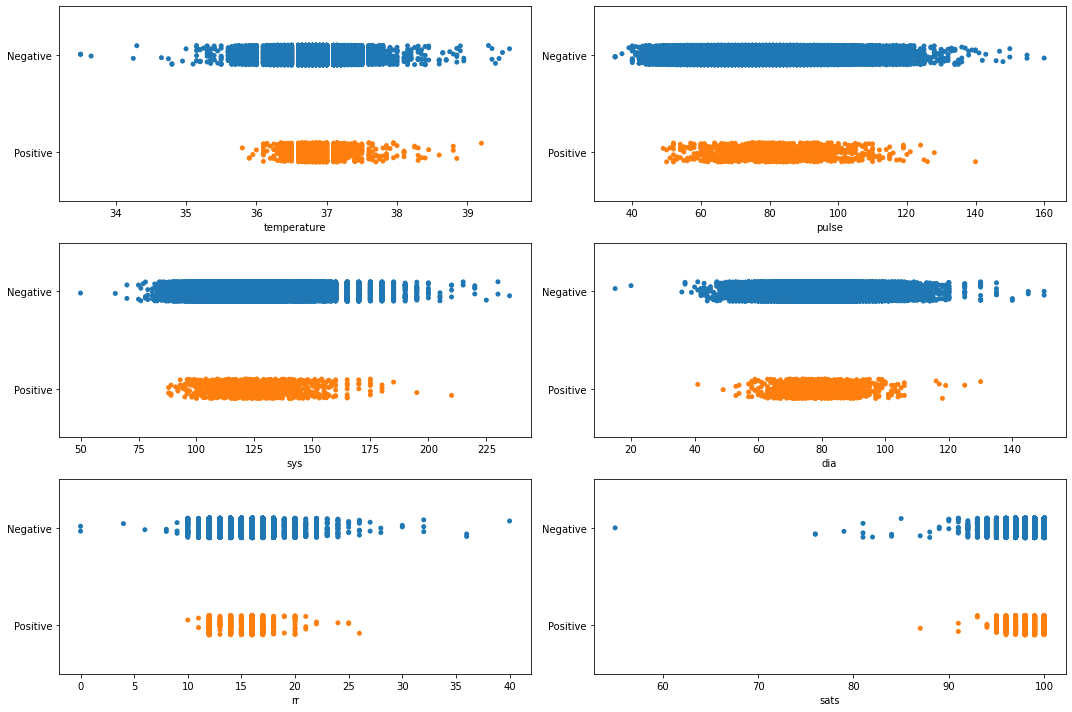

In [19]:
def plot_vitals():
    vitals = ["temperature", "pulse", "sys", "dia", "rr", "sats"]
    # 'f' is the figure (the container) where everything will be ploted. 
    # 'axes' is the array of subplots (called axes) where each subplot will be plotted (in this case an array of 3 rows and 2 columns)
    # Note: you cann add axes to figures to make them subplots
    f, axes = plt.subplots(3,2, figsize=(15,10)) 
    i = 0
    j = 0
    for feature in vitals:   
        sns.stripplot(data=all_data, x=feature, y="covid19_test_results", ax=axes[i % 3][j % 2])    #this returns an 'ax' object, which we are passing
        axes[i % 3][j % 2].set_ylabel('')
        j+=1
        if j%2 == 0:
            i+=1

    f.tight_layout()

plot_vitals()

We can observe that for almost every continuous feature there are some data points that might be considered outliers and most of them are occurring within the negative result dataset. I will establish some boundaries depending on the feature (trying to include as many positive results as possible) for each feature and then I will count how many of points exist outside those boundaries. If there are enough significant points I will replace them with the minimum value. If the number is too low then I will just drop them<i>Note: I might use nearest k-nearest-neighbor imputation as a side experiment to see how it improves the performance of the algorithm.</i><br>


| Feature | Lower bound | Upper bound |
|:-|:-:|:-:|
| Temperature | 34.5 | 39 |
| Pulse | <b>N/A</b> | 150 |
| Sys | 62.5 | 225 |
| Dia | 30 | 140 |
| RR | 7.5 | 35 |
| Sats | 80 | <b>N/A</b>|

In [20]:
print("Temperature below 34.5°:")
low_temp = all_data[all_data["temperature"]<34.5]
print(low_temp.covid19_test_results.value_counts())
print("Temperature above 39°:")
high_temp = all_data[all_data["temperature"]>39]
print(all_data[all_data["temperature"]>39].covid19_test_results.value_counts())
print("Pulse above 150:")
hi_pulse = all_data[all_data["pulse"]>150]
print(all_data[all_data["pulse"]>150].covid19_test_results.value_counts())

print("Systolic below 75:")
low_sys = all_data[all_data["sys"]<75]
print(all_data[all_data["sys"]<75].covid19_test_results.value_counts())
print("Systolic above 225:")
high_sys = all_data[all_data["sys"]>225]
print(all_data[all_data["sys"]>225].covid19_test_results.value_counts())
print("Diastolic below 30:")
low_dia = all_data[all_data["dia"]<30]
print(all_data[all_data["dia"]<30].covid19_test_results.value_counts())
print("Diastolyc above 140:")
high_dia = all_data[all_data["dia"]>140]
print(all_data[all_data["dia"]>140].covid19_test_results.value_counts())
print("Respiratory rate below 7.5:")
low_rr = all_data[all_data["rr"]<7.5]
print(all_data[all_data["rr"]<7.5].covid19_test_results.value_counts())
print("Respiratory rate above 35:")
high_rr = all_data[all_data["rr"]>35]
print(all_data[all_data["rr"]>35].covid19_test_results.value_counts())
print("Saturation level below 80:")
low_sats = all_data[all_data["sats"]<80]
print(all_data[all_data["sats"]<80].covid19_test_results.value_counts())

Temperature below 34.5°:
Negative    5
Name: covid19_test_results, dtype: int64
Temperature above 39°:
Negative    7
Positive    1
Name: covid19_test_results, dtype: int64
Pulse above 150:
Negative    3
Name: covid19_test_results, dtype: int64
Systolic below 75:
Negative    4
Name: covid19_test_results, dtype: int64
Systolic above 225:
Negative    3
Name: covid19_test_results, dtype: int64
Diastolic below 30:
Negative    2
Name: covid19_test_results, dtype: int64
Diastolyc above 140:
Negative    4
Name: covid19_test_results, dtype: int64
Respiratory rate below 7.5:
Negative    4
Name: covid19_test_results, dtype: int64
Respiratory rate above 35:
Negative    3
Name: covid19_test_results, dtype: int64
Saturation level below 80:
Negative    4
Name: covid19_test_results, dtype: int64


We can see that all of the features have a very low number of outliers (given by the thresholds I was using) so I will choose to remove all of the defective points (except for temperature above 39° becaue on second thought, values above 39° are possible values). Also I would like to note that the above cell helped me notice that indeed a point in the graph is just a point in real data, so I have decided I will also trim the positive datapoints in a separate cutoff from the negatives

In [21]:
def calculate_union(df_list):
    union = df_list[0].index
    for df in df_list:
        union = np.union1d(union, df.index)
        
    return union

def calculate_intersection(df_list):
    intersection = df_list[0].index
    for df in df_list:
        intersection = np.intersect1d(intersection, df.index)
    return intersection


In [22]:
df_list =[low_temp, hi_pulse, low_sys, high_sys, low_dia, high_dia, low_rr, high_rr, low_sats]
union = calculate_union(df_list)
intersection = calculate_intersection(df_list)

all_data.drop(index=union, inplace=True)

In [23]:
df_list = [positive_data[positive_data["pulse"] >= 140], positive_data[positive_data["sys"] >= 190], positive_data[(positive_data["dia"] <= 50) | (positive_data["dia"] >= 110)]]
union = calculate_union(df_list)
instersection = calculate_intersection(df_list)

all_data.drop(index=union, inplace=True)

### After cleaning continuous values

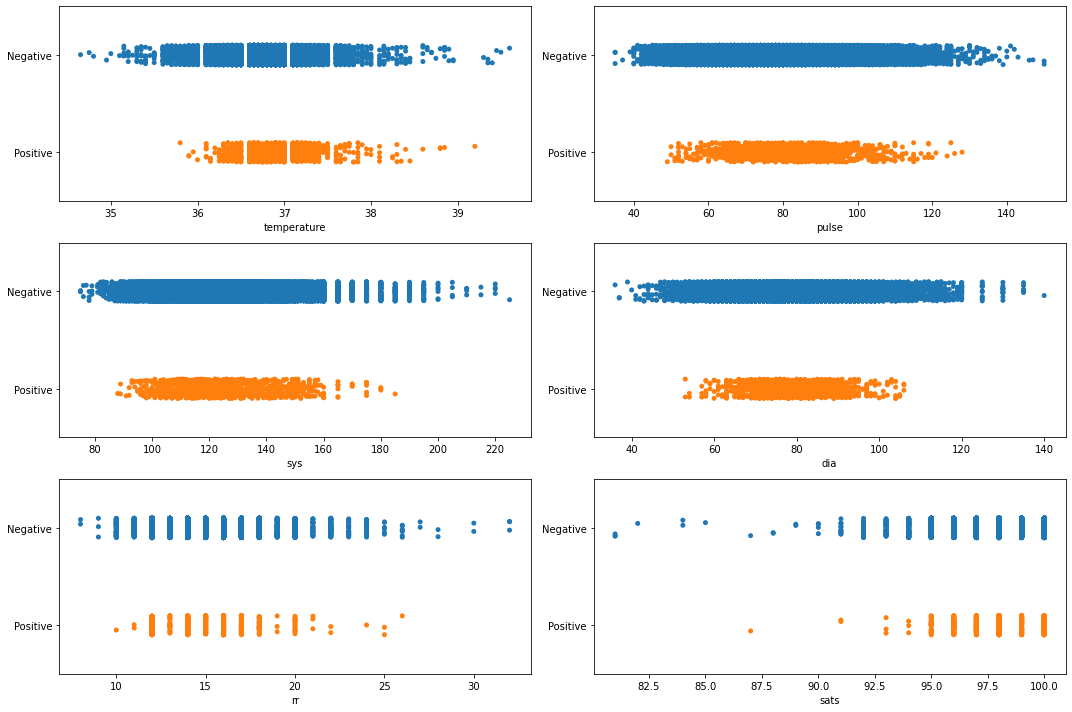

In [24]:
plot_vitals()

As the plot shows, there are still some outliers remaining. However the graphs are a bit tighter now, which will help us to infer where the bulk mass of the data is.


## Data imputation and separation in different datasets

In this part, having removed all columns that will not be used whether it is because of lack of information or because they do not provide any useful information per se, I will impute missing data for the values that have a relatively small missing portion of the data. I use the most frequent value in this type of column first. I might experiment with Imputation by most frequent neighbor

Next, for the others I will explore the option of separating them into different datasets or imputing the data.

In [25]:
#Lets see how many unique values each column has
#This will take the nans as an additional value. That's why .nunique is preferred
#for column in all_data.columns:
    #print(column, len(all_data[column].unique()), sep=": ") 

all_data.info()
all_data.nunique(axis=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93829 entries, 0 to 93994
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   covid19_test_results           93829 non-null  object 
 1   age                            93829 non-null  int64  
 2   high_risk_exposure_occupation  93660 non-null  object 
 3   high_risk_interactions         69021 non-null  object 
 4   diabetes                       93829 non-null  object 
 5   chd                            93829 non-null  object 
 6   htn                            93829 non-null  object 
 7   cancer                         93829 non-null  object 
 8   asthma                         93829 non-null  object 
 9   autoimmune_dis                 93829 non-null  object 
 10  smoker                         93829 non-null  object 
 11  temperature                    47408 non-null  float64
 12  pulse                          48143 non-null 

covid19_test_results               2
age                               95
high_risk_exposure_occupation      2
high_risk_interactions             2
diabetes                           2
chd                                2
htn                                2
cancer                             2
asthma                             2
autoimmune_dis                     2
smoker                             2
temperature                       82
pulse                            110
sys                               98
dia                               88
rr                                23
sats                              18
ctab                               2
labored_respiration                2
rhonchi                            2
wheezes                            2
days_since_symptom_onset          20
cough                              2
cough_severity                     4
fever                              2
sob                                2
sob_severity                       3
d

There are several features that need imputation (the ones with null values in the first table). However, since the dataset is going to be split in 4 it is better to start imputing the features belonging to the set with the highest number of datapoints, starting from the top to the bottom. When I reach the vitals ('Temperature', 'Pulse', etc.) I will proceed to split the dataset and then do the corresponding imputation.

<u>Age:</u> I just found in the data dictionary that the age has been added using noise, so Ill replace ages less than 0 with 0. I choose the mean since it shouldnt affect the distribution. Also I am thinking it might be a good idea to not really specify an age but make it into a group (like 0-20, 20-40, 40-60, 60-80).

In [26]:
all_data.age.describe() #First we need to find out how the data is distributed with regarding to age (the max value and middle value)

count    93829.000000
mean        39.178985
std         15.035089
min         -3.000000
25%         28.000000
50%         37.000000
75%         50.000000
max         91.000000
Name: age, dtype: float64

In [27]:
# We separate the patients in age groups, defining the bounds as the percentiles of the distribution
# Also the encoding is done directly
all_data.loc[all_data.age <= 28, "age"] = 1
all_data.loc[(all_data.age > 28) & (all_data.age <= 37), "age"] = 2
all_data.loc[(all_data.age > 37) & (all_data.age <= 50), "age"] = 3
all_data.loc[all_data.age > 50, "age"] = 4

<u>Fever and temperature:</u> It would seem a little reduntant to preserve both 'fever' and 'temperature' since one could argue one feature is dependent on the other. However, since first I will be splitting the datasets into 4 differents sets, it makes sense to preserve both. Also we have an interesting case with 'fever' being a patient-reported symptom is very likely to be less trustworthy than the reading of the temperature taken by the clinic staff, so I will replace the value of 'fever' with True if the temperature is above 38° and with False if it is below 38°. The reverse holds also true: if I have no value of fever, I will use the temperature to infer the value. <i>Note: I ended up using 37 as my threshold since using 38 yielded less fever values with positive results and in general skewed the ratio of fever as not having fever

In [28]:
#Fever data before correction
print(all_data[(all_data["covid19_test_results"] == "Positive")].fever.value_counts())
print(all_data[(all_data["covid19_test_results"] == "Negative")].fever.value_counts())

False    878
True     219
Name: fever, dtype: int64
False    68049
True      1776
Name: fever, dtype: int64


In [29]:
all_data.loc[(all_data["fever"] == True) & (all_data["temperature"] <37), "fever"] = False
all_data.loc[(all_data["fever"] == False) & (all_data["temperature"] >=37), "fever"] = True

In [30]:
#Fever data after correction
print(all_data[(all_data["covid19_test_results"] == "Positive")].fever.value_counts())
print(all_data[(all_data["covid19_test_results"] == "Negative")].fever.value_counts())

False    748
True     349
Name: fever, dtype: int64
False    60033
True      9792
Name: fever, dtype: int64


I also encode the only categorical values we now have in the whole dataset: cough_severity and sob_severity

In [31]:
#This part is to encode cough_severity and sob_severity

all_data.loc[all_data["cough_severity"] == 'None', "cough_severity"] = 0
all_data.loc[all_data["cough_severity"] == 'Mild', "cough_severity"] = 1
all_data.loc[all_data["cough_severity"] == 'Moderate', "cough_severity"] = 2
all_data.loc[all_data["cough_severity"] == 'Severe', "cough_severity"] = 3

all_data.loc[all_data["sob_severity"] == 'None', "sob_severity"] = 0
all_data.loc[all_data["sob_severity"] == 'Mild', "sob_severity"] = 1
all_data.loc[all_data["sob_severity"] == 'Moderate', "sob_severity"] = 2
all_data.loc[all_data["sob_severity"] == 'Severe', "sob_severity"] = 3

Finally, before I separate the data I want to leave this as a reference of the values that exist within the dataset (some of which I might remove later)

In [32]:
#This might be useful later
print("Positve values")
all_data.drop_duplicates(inplace=True)
for column in all_data.columns:
    if all_data[column].nunique() <= 2:
        print(all_data.loc[all_data["covid19_test_results"] == "Positive", column].value_counts())

print("Negative values")
for column in all_data.columns:
    if all_data[column].nunique() <= 2:
        print(all_data.loc[all_data["covid19_test_results"] == "Negative", column].value_counts())

Positve values
Positive    1222
Name: covid19_test_results, dtype: int64
False    1005
True      213
Name: high_risk_exposure_occupation, dtype: int64
False    820
True     209
Name: high_risk_interactions, dtype: int64
False    1195
True       27
Name: diabetes, dtype: int64
False    1212
True       10
Name: chd, dtype: int64
False    1138
True       84
Name: htn, dtype: int64
False    1217
True        5
Name: cancer, dtype: int64
False    1188
True       34
Name: asthma, dtype: int64
False    1220
True        2
Name: autoimmune_dis, dtype: int64
False    1160
True       62
Name: smoker, dtype: int64
False    714
True     160
Name: ctab, dtype: int64
False    1045
True       13
Name: labored_respiration, dtype: int64
False    482
True     101
Name: rhonchi, dtype: int64
False    536
True     146
Name: wheezes, dtype: int64
False    799
True     423
Name: cough, dtype: int64
False    700
True     348
Name: fever, dtype: int64
False    1098
True      120
Name: sob, dtype: int64
False   

In [33]:
for column in all_data.columns:
    if all_data[column].dtype == "object":
        print(column + ":", all_data[column].unique(), "NaN values:", all_data[column].isna().sum())        


covid19_test_results: ['Negative' 'Positive'] NaN values: 0
high_risk_exposure_occupation: [True False nan] NaN values: 58
high_risk_interactions: [nan True False] NaN values: 4206
diabetes: [False True] NaN values: 0
chd: [False True] NaN values: 0
htn: [False True] NaN values: 0
cancer: [False True] NaN values: 0
asthma: [False True] NaN values: 0
autoimmune_dis: [False True] NaN values: 0
smoker: [False True] NaN values: 0
ctab: [False nan True] NaN values: 16946
labored_respiration: [False nan True] NaN values: 5269
rhonchi: [False nan True] NaN values: 28742
wheezes: [False nan True] NaN values: 24672
cough: [True False nan] NaN values: 11
cough_severity: [3 1 0 2 nan] NaN values: 11
fever: [nan False True] NaN values: 3250
sob: [False nan True] NaN values: 93
sob_severity: [0 nan 2 1] NaN values: 93
diarrhea: [False nan True] NaN values: 76
fatigue: [False nan True] NaN values: 65
headache: [False nan True] NaN values: 72
loss_of_smell: [False nan True] NaN values: 79
loss_of_tas

### Separation into training, validation and testing sets.

Before I proceed any further, I think it is important that I separate the data into training, validation and testing sets. The purpose of doing this before any kind of imputation takes place so there is no target leakage in any of our experiments (ie. it is possible that we might find data points with nan values).

In [34]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(all_data.drop(columns="covid19_test_results"), all_data["covid19_test_results"], test_size=0.3)
val_x, test_x, val_y, test_y = train_test_split(val_x, val_y, test_size=0.3)

Before I split the data further into the 4 types of sets we will use for each model, I shall take care of the following variables, since they are not part of any large group

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [35]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = data_x.high_risk_exposure_occupation.mode()[0]
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

In [36]:
train_x["high_risk_exposure_occupation"].isna().sum()

44

In [37]:
high_risk_exposure_imputation(train_x, train_y, target_imputation=True)
train_x["high_risk_exposure_occupation"].isna().sum()

0

## Splitting the data

Given that the data appears in the dictionary as taken by blocks (and seen how that matches the proportion of null values for every group) I have decided to split the data into the 4 types:<br>
- <u>Epidemiological factors:</u> 'age', 'high_risk_exposure_occupation' and 'high_risk_interactions'. These will be included in all datasets since I believe it might affect the results greatly and could be easily ignored for experimentation purposes. 
- <u>Comorbidities:</u> All columns from 'diabetes' to 'smoker'. Since this is the most complete dataset (almost all instances in the original dataset are not null) we will start with this.
- <u>Vitals:</u> All of the continues values ('temperature', 'pulse', etc.) I try to use simple linear regression and compare it against both trees and xgboost algorithms.
- <u>Clinician Assessed symptoms:</u> 'ctab', 'labored_respiration', 'rhonchi' and 'wheezes'. I will use naive bayes, trees and/or xgboost.
- <u>Patient reported symptoms:</u> All remaining columns. Again, naive bayes, trees and/or xgboost.

After I have each dataset, I will impute the null corresponding to the most frequent in each case and train several models for each one of them

In [38]:
#The data inside the training dataset
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36186 entries, 13544 to 54377
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            36186 non-null  int64  
 1   high_risk_exposure_occupation  36186 non-null  object 
 2   high_risk_interactions         36186 non-null  object 
 3   diabetes                       36186 non-null  object 
 4   chd                            36186 non-null  object 
 5   htn                            36186 non-null  object 
 6   cancer                         36186 non-null  object 
 7   asthma                         36186 non-null  object 
 8   autoimmune_dis                 36186 non-null  object 
 9   smoker                         36186 non-null  object 
 10  temperature                    32882 non-null  float64
 11  pulse                          33387 non-null  float64
 12  sys                            32199 non-n

In [39]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10-16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 1-21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [40]:
train_ef, train_comorb, train_vitals, train_as, train_rs = create_different_datasets(train_x)
valid_ef, valid_comorb, valid_vitals, valid_as, valid_rs = create_different_datasets(val_x)

In [41]:
train_x.loc[train_y=="Positive"]

,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,smoker,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
90058,2,False,True,False,False,False,False,False,False,True,...,False,0,False,False,True,False,False,True,False,False
17170,4,False,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,False
19592,2,False,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,False
85087,1,False,False,False,False,False,False,False,False,False,...,False,0,False,True,False,False,False,False,False,True
15813,2,True,True,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33185,3,False,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,False
47344,2,False,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,False
23953,4,False,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,True,False,False
33743,2,False,False,False,False,False,False,False,False,False,...,False,0,False,False,False,False,False,False,False,False


## Comorbidities

Before I jump directly into evaluating the performance of the algorithm, I will take this opportunity to actually build a Naive Bayes model myself, using what I know about the algorithm. Afterwards, I will evaluate my model against the sklearn version to see how it did.

<i>Note: without knowing I implemented Categorical Naive bayes instead of the intended multinomial naive bayes. The only difference between these 2 is the way the probability of the feature values are calculated. More info on the code's comments</i>

### Implementation of NaiveBayes algorithm

In [42]:
class NaiveBayes:
    
    def __init__(self):
        self.probs = []
        self.priors = None
        self.prob_classes = None
        self.class_labels = None
        
    def fit(self, data_x, data_y, priors=None):
        
        self.class_labels = data_y.unique()
        if priors is not None:
            self.priors =priors         
        else:
            self.priors = []
            
        for target_class in self.class_labels:
            data_points_in_class = (data_y == target_class).sum() #This is for categorical naive bayes
            total_number_of_features = (data_x[data_y == target_class].values.sum()) #This is for multinomial naive bayes. In this case, it represents how many comorbidities actually exist in the class
            if priors is None:
                self.priors.append(data_points_in_class/len(data_x))
            class_probs = []
            for feature in data_x.columns:                
                prob_dict = {}
                for value in np.unique(data_x[feature]):
                    #The way we calculate the probability changes according to the type of naive bayes we are using
                    prob_dict[value] = (len(data_x[(data_x[feature] == value) & (data_y==target_class)]))/ total_number_of_features #Multinomial naive bayes
                    prob_dict[value] = (len(data_x[(data_x[feature] == value) & (data_y==target_class)]))/ data_points_in_class #Categorical naive bayes
                
                class_probs.append(prob_dict)
            self.probs.append(class_probs)
        
    def _predict(self, data_x):
        prob_classes = []
        for i in range(len(self.priors)): #Iterates times the number of classes so we end up with a probability for each class
            result_prob = self.priors[i]            
            j=0
            for feature_array in self.probs[i]:
                result_prob *= feature_array[data_x.iloc[j]]
                j+=1
            prob_classes.append(result_prob)
        return self.class_labels[[x for x in enumerate(prob_classes) if x[1] == max(prob_classes)][0][0]] #Returns the index of the class with highest probability
                            
            
    def predict(self, data_x):    
        return data_x.apply(self._predict, axis=1).values
        

### Comparing my implementation of Naive Bayes with the sklearn implementations

In [43]:
nb = NaiveBayes()
nb.fit(train_comorb, train_y)
custom = nb.predict(valid_comorb)
custom

array(['Negative', 'Negative', 'Negative', ..., 'Negative', 'Negative',
       'Negative'], dtype=object)

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB

sk_nb = CategoricalNB(alpha=0) #The alpha value is used to add one to every count of the values to avoid a 0 probability. I set it here to 0 since my implementation doesn't use any alpha values
sk_nb.fit(train_comorb, train_y)
result = sk_nb.predict(valid_comorb)
result

C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


array(['Negative', 'Negative', 'Negative', ..., 'Negative', 'Negative',
       'Negative'], dtype='<U8')

In [45]:
(custom != result).sum() # Results from both algorithms are the same

0

The priors from both algorithms are the same (after applying exponential function to the ones in the sklearn algorithm)

In [46]:
from math import log, exp

#We use the exp function since the probabilities in the sklearn algorithms are log_probabilities (and the inverse of log is 'exp')
for p in sk_nb.class_log_prior_:
    print(exp(p))
    
nb.priors

0.9759575526446688
0.024042447355330798


[0.9759575526446692, 0.02404244735533079]

In [47]:
#The first one is to obtain the probabilities of MultinomialNB while the second for obtaining the probs of CategoricalNB from sklearn
#for i in sk_nb.feature_log_prob_.flatten():
#    print(exp(i))
    
for i in sk_nb.feature_log_prob_:
    print(exp(i[1,1])) 

0.022988505747236085
0.009195402298963404
0.0712643678161905
0.00459770114953917
0.024137931034592146
0.0022988505748270573
0.05287356321849357


In [48]:
nb.probs

[[{False: 0.9899195831917544, True: 0.010080416808245554},
  {False: 0.9928077925019821, True: 0.007192207498017896},
  {False: 0.9300033978933061, True: 0.06999660210669385},
  {False: 0.995384528259146, True: 0.0046154717408540035},
  {False: 0.959253596103749, True: 0.04074640389625099},
  {False: 0.9956393702571072, True: 0.00436062974289274},
  {False: 0.9389511835995017, True: 0.061048816400498356}],
 [{False: 0.9770114942528736, True: 0.022988505747126436},
  {False: 0.9908045977011494, True: 0.009195402298850575},
  {False: 0.9287356321839081, True: 0.07126436781609195},
  {False: 0.9954022988505747, True: 0.004597701149425287},
  {False: 0.9758620689655172, True: 0.02413793103448276},
  {False: 0.9977011494252873, True: 0.0022988505747126436},
  {False: 0.9471264367816092, True: 0.052873563218390804}]]

### Using Naive Bayes to predict the test result

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
mn_nb = MultinomialNB(alpha=0, class_prior=(.5,.5))
#train_comorb.drop_duplicates(inplace=True)
mn_nb.fit(train_comorb, train_y[train_comorb.index])
values = (val_y, mn_nb.predict(valid_comorb)) #we are going to be using the values in this order for many different metrics so we might as well save the tuple
values_train = (train_y, mn_nb.predict(train_comorb)) #training values, to see bias/variance trade off
confusion_matrix(*values)

C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


array([[9825,  798],
       [ 218,   15]], dtype=int64)

In [50]:
#I didn't find a measure of specificity in the sklearn.metrics library
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    true_negatives = cm[0][0]
    false_positives = cm[1][0]
    return true_negatives/(true_negatives + false_positives)

In [51]:
from colorama import Fore #To pain the terminal with different colors

def print_metrics(values, values_training):
    # These are the 4 metrics that we would like to improve
    print("Accuracy:", accuracy_score(*values))
    print("Recall:", recall_score(*values, pos_label="Positive")) #I think I will use recall since it is the one I want to reduce
    print("F1 Score:", f1_score(*values, average="weighted")) #The weighted average is for it to account the imbalances in the dataset
    print(Fore.BLUE, confusion_matrix(*values), Fore.BLACK)
    print("")
    print("Accuracy (training):", accuracy_score(*values_training))
    print("Recall (training):", recall_score(*values_training, pos_label="Positive")) #I think I will use recall since it is the one I want to reduce
    print("F1 Score (training):", f1_score(*values_training, average="weighted")) #The weighted average is for it to account the imbalances in the dataset
    print(Fore.BLUE, confusion_matrix(*values_training), Fore.BLACK)
    
def get_metrics(*values):
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    return accuracy, recall, precision, f1

In [52]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

This time I will try to train by just using a random selection of negative samples (the same number as all positive samples) against all positive

In [53]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

In [54]:
from xgboost import XGBClassifier

class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params)
        
    def fit(self, data_x, data_y):
        self.model.fit(self.xgb_adapter(data_x), data_y)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
        
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            result.loc[:,column] = result[column].astype("bool")
        return result



In [63]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
def run_models(models, train_x, valid_x, train_y, valid_y):
    for model in models:
        print(Fore.RED, "Model:", model, Fore.BLACK)        
        print("Training...",end="")
        models[model].fit(train_x, train_y)
        print("complete!!")
        print("Predicting data...",end="")
        values = (valid_y, models[model].predict(valid_x))
        values_train = (train_y, models[model].predict(train_x))
        print("complete!!")
        print_metrics(values, values_train)        
        print("\n")
        
def cross_validation_results(models, data_x, data_y):
    metrics = {
        "Accuracy" : make_scorer(accuracy_score),
        "Recall" : make_scorer(recall_score, pos_label="Positive"),
        "F1 Score" : make_scorer(f1_score, average="weighted")
    }
    
    for model in models:  
        print(Fore.RED, "Model:", model, Fore.BLACK)  
        cross_val_results = cross_validate(models[model], train_x, train_y, scoring=metrics, cv=10, return_train_score=True)
        print(cross_val_results)
        
def cross_validation_custom(data_x, data_y, model, folds):
    results = np.zeros((folds,2,4)) #Shape of folds, training and validation, and number of metrics
    
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds
    
    start = 0
    
    for i in range(folds):
        print("Fold ", i, ":")
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        print("Separating data...", end="")
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y.iloc[:start].append(data_y.iloc[end:])
        valid_x = data_x.iloc[start:end]
        valid_y = data_y.iloc[start:end]
        print("Done!!")
        print("Training...", end="")
        model.fit(train_x, train_y)
        print("Done!!")
        print("Predicting...", end="")
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        print("Done!!")
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
    
    return results.mean(axis=0)
        
def run_models_cross_val(data_x, data_y, models, folds):
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        results = cross_validation_custom(data_x, data_y, models[model], folds)       
        print(Fore.BLUE, results, Fore.BLUE, sep="")
        print("")

In [59]:
models ={
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5,.5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=30),
    "Random Forest (500 estimators)" : RandomForestClassifier(n_estimators = 500),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC()    
}

In [62]:
run_models(models, train_comorb, valid_comorb, train_y, val_y)
#cross_validation_results(models,valid_comorb, val_y)

 Model: MultinomialNB 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.900792188651437
Recall: 0.08243727598566308


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


F1 Score: 0.9243875172542876
 [[9756  821]
 [ 256   23]] 

Accuracy (training): 0.9040512905543581
Recall (training): 0.0869047619047619
F1 Score (training): 0.92839672154921
 [[32641  2705]
 [  767    73]] 


 Model: Random Forest (100 estimators) 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.9742999263080324
Recall: 0.0
F1 Score: 0.9616171623720486
 [[10577     0]
 [  279     0]] 

Accuracy (training): 0.9767866025534737
Recall (training): 0.0
F1 Score (training): 0.9653162012485342
 [[35346     0]
 [  840     0]] 


 Model: Random Forest (500 estimators) 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.9742999263080324
Recall: 0.0
F1 Score: 0.9616171623720486
 [[10577     0]
 [  279     0]] 

Accuracy (training): 0.9767866025534737
Recall (training): 0.0
F1 Score (training): 0.9653162012485342
 [[35346     0]
 [  840     0]] 


 Model: XGBoost Classifier 
Training...[21:45:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/

C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


complete!!
Predicting data...complete!!
Accuracy: 0.9742999263080324
Recall: 0.0
F1 Score: 0.9616171623720486
 [[10577     0]
 [  279     0]] 

Accuracy (training): 0.9767866025534737
Recall (training): 0.0
F1 Score (training): 0.9653162012485342
 [[35346     0]
 [  840     0]] 


 Model: SVM 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.9742999263080324
Recall: 0.0
F1 Score: 0.9616171623720486
 [[10577     0]
 [  279     0]] 

Accuracy (training): 0.9767866025534737
Recall (training): 0.0
F1 Score (training): 0.9653162012485342
 [[35346     0]
 [  840     0]] 




As we can see, the performance doesn't improve very much by taking only an equivalent sample of the negatives into the positives. I also ran into the problem that I forgot to remove duplicates from the dataset. I don't know if I should keep it that way or no. It is worth noting that it mostly affects the comorbidities (since it is the set that was 'most complete').

Next I'll try both a random forest and an XGBoost classifier, first with the regular training dataset and then with the reduced dataset (the one that has the same amount of negative samples as positive samples)

In [63]:
reduced_train_comorb = reduce_training_set(train_comorb, train_y)

In [64]:
run_models(models, reduced_train_comorb, valid_comorb, train_y[reduced_train_comorb.index], val_y)

 Model: MultinomialNB 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.9513633014001474
Recall: 0.025089605734767026
F1 Score: 0.9506637960298329
 [[10321   256]
 [  272     7]] 

Accuracy (training): 0.5053571428571428
Recall (training): 0.03571428571428571


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


F1 Score (training): 0.36538327789846625
 [[819  21]
 [810  30]] 


 Model: Random Forest (100 estimators) 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.9742999263080324
Recall: 0.0
F1 Score: 0.9616171623720486
 [[10577     0]
 [  279     0]] 

Accuracy (training): 0.5
Recall (training): 0.0
F1 Score (training): 0.3333333333333333
 [[840   0]
 [840   0]] 


 Model: Random Forest (500 estimators) 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.170412675018423
Recall: 0.8673835125448028
F1 Score: 0.25768027453175213
 [[1608 8969]
 [  37  242]] 

Accuracy (training): 0.5136904761904761
Recall (training): 0.8761904761904762
F1 Score (training): 0.44011855506728687
 [[127 713]
 [104 736]] 


 Model: XGBoost Classifier 
Training...

C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:45:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
complete!!
Predicting data...complete!!
Accuracy: 0.17078113485630067
Recall: 0.8673835125448028
F1 Score: 0.2582344769332144
 [[1612 8965]
 [  37  242]] 

Accuracy (training): 0.5136904761904761
Recall (training): 0.8738095238095238
F1 Score (training): 0.44122538293216634
 [[129 711]
 [106 734]] 


 Model: SVM 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.16857037582903464
Recall: 0.8673835125448028
F1 Score: 0.2549038246564289
 [[1588 8989]
 [  37  242]] 

Accuracy (training): 0.5136904761904761
Recall (training): 0.8761904761904762
F1 Score (training): 0.44011855506728687
 [[127 713]
 [104 736]] 




It seems that I might either drop duplicates from the beginning or add more variables. Next step will be to add age, high_risk_occupation and high_risk_interaction to the datasets to see how it performs

In [65]:
train_comorb_ef = pd.concat([train_comorb, train_ef], axis=1)
valid_comorb_ef = pd.concat([valid_comorb, valid_ef], axis=1)
high_risk_exposure_imputation(train_comorb_ef, train_y, target_imputation=True)
high_risk_exposure_imputation(valid_comorb_ef, val_y, target_imputation=False)
reduced_train_comorb_ef = reduce_training_set(train_comorb_ef, train_y)

In [66]:
run_models(models, train_comorb_ef, valid_comorb_ef, train_y, val_y)

 Model: MultinomialNB 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.28021370670596907
Recall: 0.8279569892473119


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


F1 Score: 0.4091091532073699
 [[2811 7766]
 [  48  231]] 

Accuracy (training): 0.2822638589509755
Recall (training): 0.805952380952381
F1 Score (training): 0.41475470661276603
 [[ 9537 25809]
 [  163   677]] 


 Model: Random Forest (100 estimators) 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.9742999263080324
Recall: 0.0
F1 Score: 0.9616171623720486
 [[10577     0]
 [  279     0]] 

Accuracy (training): 0.9767866025534737
Recall (training): 0.0
F1 Score (training): 0.9653162012485342
 [[35346     0]
 [  840     0]] 


 Model: Random Forest (500 estimators) 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.9742999263080324
Recall: 0.0
F1 Score: 0.9616171623720486
 [[10577     0]
 [  279     0]] 

Accuracy (training): 0.9769247775382744
Recall (training): 0.005952380952380952
F1 Score (training): 0.965658395159037
 [[35346     0]
 [  835     5]] 


 Model: XGBoost Classifier 
Training...[21:45:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


complete!!
Predicting data...complete!!
Accuracy: 0.9742999263080324
Recall: 0.0
F1 Score: 0.9616171623720486
 [[10577     0]
 [  279     0]] 

Accuracy (training): 0.9768418725473941
Recall (training): 0.002380952380952381
F1 Score (training): 0.9654534691981698
 [[35346     0]
 [  838     2]] 


 Model: SVM 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.9742999263080324
Recall: 0.0
F1 Score: 0.9616171623720486
 [[10577     0]
 [  279     0]] 

Accuracy (training): 0.9767866025534737
Recall (training): 0.0
F1 Score (training): 0.9653162012485342
 [[35346     0]
 [  840     0]] 




In [67]:
run_models(models, reduced_train_comorb_ef, valid_comorb_ef, train_y[reduced_train_comorb_ef.index], val_y)

 Model: MultinomialNB 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.8182571849668386
Recall: 0.21505376344086022
F1 Score: 0.8777921834068566
 [[8823 1754]
 [ 219   60]] 



C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Accuracy (training): 0.5238095238095238
Recall (training): 0.21785714285714286
F1 Score (training): 0.47463142110636997
 [[697 143]
 [657 183]] 


 Model: Random Forest (100 estimators) 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.44178334561532795
Recall: 0.6594982078853047
F1 Score: 0.5894680798693731
 [[4612 5965]
 [  95  184]] 

Accuracy (training): 0.549404761904762
Recall (training): 0.6523809523809524
F1 Score (training): 0.5445753957695532
 [[375 465]
 [292 548]] 


 Model: Random Forest (500 estimators) 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.4043846720707443
Recall: 0.6917562724014337
F1 Score: 0.5518026701701771
 [[4197 6380]
 [  86  193]] 

Accuracy (training): 0.5672619047619047
Recall (training): 0.6916666666666667
F1 Score (training): 0.5604593339592814
 [[372 468]
 [259 581]] 


 Model: XGBoost Classifier 
Training...[21:45:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting i

C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


complete!!
Predicting data...complete!!
Accuracy: 0.2417096536477524
Recall: 0.8566308243727598
F1 Score: 0.35884854220550255
 [[2385 8192]
 [  40  239]] 

Accuracy (training): 0.5404761904761904
Recall (training): 0.8535714285714285
F1 Score (training): 0.490533930622487
 [[191 649]
 [123 717]] 


 Model: SVM 
Training...complete!!
Predicting data...complete!!
Accuracy: 0.47476050110537954
Recall: 0.6057347670250897
F1 Score: 0.6212550707119556
 [[4985 5592]
 [ 110  169]] 

Accuracy (training): 0.5517857142857143
Recall (training): 0.5952380952380952
F1 Score (training): 0.5509378357875964
 [[427 413]
 [340 500]] 




In [64]:
run_models_cross_val(train_comorb, train_y, models, 10)

MultinomialNB
Fold  0 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Fold  1 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Fold  2 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Fold  3 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Fold  4 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Fold  5 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Fold  6 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Fold  7 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Fold  8 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


Fold  9 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


[[0.90403594 0.08873804 0.0279965  0.04255736]
 [0.90396826 0.08152917 0.0264414  0.03973918]]

Random Forest (100 estimators)
Fold  0 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  1 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  2 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  3 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  4 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  5 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  6 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  7 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  8 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  9 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[0.97595755 0.         0.         0.        ]
 [0.97595749 0.         0.         0.        ]]

Random Forest (500 estimators)
Fold  0 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  1 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  2 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  3 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  4 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  5 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  6 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  7 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  8 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  9 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[0.97595755 0.         0.         0.        ]
 [0.97595749 0.         0.         0.        ]]

XGBoost Classifier
Fold  0 :
Separating data...Done!!
Training...[00:17:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Done!!
Predicting...Done!!
Fold  1 :
Separating data...Done!!
Training...[00:17:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Done!!
Predicting...Done!!
Fold  2 :
Separating data...Done!!
Training...[00:17:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Done!!
Predicting...Done!!
Fold  3 :
Separating data...Done!!
Training...[00:17:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric us

C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  1 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  2 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  3 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  4 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  5 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  6 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  7 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  8 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold  9 :
Separating data...Done!!
Training...Done!!
Predicting...Done!!


C:\ProgramData\Miniconda3\envs\basicML\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[0.97595755 0.         0.         0.        ]
 [0.97595749 0.         0.         0.        ]]

